<a href="https://colab.research.google.com/github/larixgomex/customer_segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overview

Wolt, a popular online food delivery company, recognizes the importance of understanding their user base to better serve their customers. To achieve this, I'll create a detailed user segmentation based on the available data.

The dataset I'm working with consists of some machine-generated user data of a food delivery application. Each row represents a unique customer who has registered to use the service from September 2019 to October 2020. During this period, the customers might have made purchases from the app or not.

### Objective



To accomplish this goal, I'm performing a RFM (Recency, Frequency, Monetary) analysis. This analysis will allow to segment their users into distinct groups based on their purchasing behavior, such as the frequency of orders, the amount spent, and how recently they placed their last order. By doing so, Wolt will be able to identify their most valuable customers and determine the areas that require more attention in order to retain them.

The insights gained from this analysis will enable the company to tailor their services to meet the needs of different user segments. For instance, they may offer personalized discounts to users who have not ordered in a while, or they may provide a better loyalty program to their most frequent users.

**Steps**

*   Data Preprocessing & Exploration
*   Data Cleaning & Initial Analysis
*   RFM Analysis
*   Evaluating the Skewness and Scaling
*   K-Means Analysis with elbow method
*   Analysis of the Clusters
*   Interpretation of the Results



## ‚öôÔ∏è Config

**Libraries**

In [1]:
### Installing dependencies ###
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


**Functions**

In [2]:
# percentage of missing data for each column

def table_review(df):
    isnull = df.isnull().sum()
    type_columns = df.dtypes
    pre = round((isnull/len(df))*100, 2)
    dc = pd.DataFrame({"Type":type_columns,
                       "Isnull":isnull,
                       "Missing data Ÿ™":pre})
    print(dc.sort_values(by = "Missing data Ÿ™", ascending = False))

In [3]:
# counts the number of days between the registration date and the first order date.

def first_order(df):
    registr_date = df['registration_date']
    order_date = df['first_purchase_day']
    wating_day = order_date - registr_date
    total = len(wating_day)
    wating_table = pd.DataFrame({"Wating_day": wating_day, "count": 1})
    count_wating_day = wating_table.groupby(["Wating_day"]).count().sort_values("count", ascending = False)
    count_wating_day.reset_index(drop = True, inplace = True)
    count_wating_day["percentage %"] = (count_wating_day["count"]/total)*100
    return count_wating_day

def first_order_plot():
    first_or = first_order(df)
    plt.plot(first_or["percentage %"], "-", color = "#C71585")
    plt.ylabel("first order", size = 12, c = "black")
    plt.xlabel("days", size = 12, c = "black")
    plt.title("How long does it take until the first order after registration", size = 12, color = "black")
    plt.show()

**Colors**

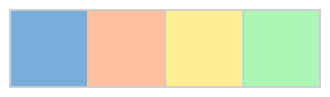

In [4]:
# custom palette
customPalette = ['#79ADDC','#FFC09F','#FFEE93','#ADF7B6']
sns.set_palette(customPalette)
sns.palplot(customPalette)

# for plotly
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4']

## üåà Data Preprocessing and Exploration

In [5]:
df = pd.read_csv('dataset_for_analyst_assignment_20201120.csv')
df.head()
print(list(df))

['REGISTRATION_DATE', 'REGISTRATION_COUNTRY', 'PURCHASE_COUNT', 'PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY', 'FIRST_PURCHASE_DAY', 'LAST_PURCHASE_DAY', 'USER_ID', 'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES', 'DINNER_PURCHASES', 'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR', 'DISTINCT_PURCHASE_VENUE_COUNT', 'MIN_PURCHASE_VALUE_EUR', 'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 'PREFERRED_DEVICE', 'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES', 'PREFERRED_RESTAURANT_TYPES', 'USER_HAS_VALID_PAYMENT_METHOD', 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE', 'MOST_COMMON_WEEKDAY_TO_PURCHASE', 'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES', 'AVERAGE_DELIVERY_DISTANCE_KMS', 'PURCHASE_COUNT_BY_STORE_TYPE']


In [6]:
# lower case the columns for readability
df.columns = df.columns.str.lower()
df.head()

registration_date registration_country  purchase_count  \
0  2019-09-01 00:00:00.000                  DNK               0   
1  2019-09-01 00:00:00.000                  FIN               1   
2  2019-09-01 00:00:00.000                  DNK              19   
3  2019-09-01 00:00:00.000                  FIN               0   
4  2019-09-01 00:00:00.000                  GRC               0   

   purchase_count_delivery  purchase_count_takeaway       first_purchase_day  \
0                      NaN                      NaN                      NaN   
1                      1.0                      0.0  2020-09-02 00:00:00.000   
2                     19.0                      0.0  2019-12-10 00:00:00.000   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

         last_purchase_day  user_id  breakfast_purchases  lunch_purchases  \
0                      NaN        1                  NaN              NaN   
1  2020-09-02 00:00:00.000        2                  0.0              1.0   
2  2020-05-25 00:00:00.000        3                  0.0              4.0   
3                      NaN        4                  NaN              NaN   
4                      NaN        5                  NaN              NaN   

   ...  web_purchases  android_purchases  preferred_restaurant_types  \
0  ...            NaN                NaN                         NaN   
1  ...            0.0                1.0                         NaN   
2  ...           19.0                0.0                         NaN   
3  ...            NaN                NaN                         NaN   
4  ...            NaN                NaN                         NaN   

   user_has_valid_payment_method  most_common_hour_of_the_day_to_purchase  \
0                          False                                      NaN   
1                          False                                     23.0   
2                           True                                     21.0   
3                          False                                      NaN   
4                          False                                      NaN   

   most_common_weekday_to_purchase  avg_days_between_purchases  \
0                              NaN                         NaN   
1                              2.0                         NaN   
2                              2.0                         9.0   
3                              NaN                         NaN   
4                              NaN                         NaN   

   median_days_between_purchases average_delivery_distance_kms  \
0                            NaN                           NaN   
1                            NaN                         6.853   
2                            3.0                         6.559   
3                            NaN                           NaN   
4                            NaN                           NaN   

                        purchase_count_by_store_type  
0  {\n  "General merchandise": 0,\n  "Grocery": 0...  
1  {\n  "General merchandise": 0,\n  "Grocery": 0...  
2  {\n  "General merchandise": 1,\n  "Grocery": 9...  
3  {\n  "General merchandise": 0,\n  "Grocery": 0...  
4  {\n  "General merchandise": 0,\n  "Grocery": 0...  

[5 rows x 30 columns]

In [7]:
# load the store type column
import json
purchase_df = df['purchase_count_by_store_type'].apply(json.loads)
purchase_df = pd.DataFrame(purchase_df.tolist())
purchase_df

General merchandise  Grocery  Pet supplies  Restaurant  Retail store
0                        0        0             0           0             0
1                        0        0             0           1             0
2                        1        9             0           9             0
3                        0        0             0           0             0
4                        0        0             0           0             0
...                    ...      ...           ...         ...           ...
21978                    0        0             0           1             0
21979                    0        0             0           0             0
21980                    0        0             0           0             0
21981                    0        0             0           0             0
21982                    0        0             0           1             0

[21983 rows x 5 columns]

## ‚ö°Ô∏è Data Cleaning & Initial Findings

In [8]:
# append store type to the df
df = pd.merge(df, purchase_df, left_index=True, right_index=True)
df = df.drop(['purchase_count_by_store_type'],axis=1)
df.head()

registration_date registration_country  purchase_count  \
0  2019-09-01 00:00:00.000                  DNK               0   
1  2019-09-01 00:00:00.000                  FIN               1   
2  2019-09-01 00:00:00.000                  DNK              19   
3  2019-09-01 00:00:00.000                  FIN               0   
4  2019-09-01 00:00:00.000                  GRC               0   

   purchase_count_delivery  purchase_count_takeaway       first_purchase_day  \
0                      NaN                      NaN                      NaN   
1                      1.0                      0.0  2020-09-02 00:00:00.000   
2                     19.0                      0.0  2019-12-10 00:00:00.000   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

         last_purchase_day  user_id  breakfast_purchases  lunch_purchases  \
0                      NaN        1                  NaN              NaN   
1  2020-09-02 00:00:00.000        2                  0.0              1.0   
2  2020-05-25 00:00:00.000        3                  0.0              4.0   
3                      NaN        4                  NaN              NaN   
4                      NaN        5                  NaN              NaN   

   ...  most_common_hour_of_the_day_to_purchase  \
0  ...                                      NaN   
1  ...                                     23.0   
2  ...                                     21.0   
3  ...                                      NaN   
4  ...                                      NaN   

   most_common_weekday_to_purchase  avg_days_between_purchases  \
0                              NaN                         NaN   
1                              2.0                         NaN   
2                              2.0                         9.0   
3                              NaN                         NaN   
4                              NaN                         NaN   

   median_days_between_purchases  average_delivery_distance_kms  \
0                            NaN                            NaN   
1                            NaN                          6.853   
2                            3.0                          6.559   
3                            NaN                            NaN   
4                            NaN                            NaN   

   General merchandise  Grocery  Pet supplies Restaurant  Retail store  
0                    0        0             0          0             0  
1                    0        0             0          1             0  
2                    1        9             0          9             0  
3                    0        0             0          0             0  
4                    0        0             0          0             0  

[5 rows x 34 columns]

In [9]:
table_review(df)


                                            Type  Isnull  Missing data Ÿ™
preferred_restaurant_types                object   19289           87.75
median_days_between_purchases            float64   14151           64.37
avg_days_between_purchases               float64   14151           64.37
first_purchase_day                        object   10019           45.58
last_purchase_day                         object    9956           45.29
average_delivery_distance_kms            float64    9955           45.28
most_common_weekday_to_purchase          float64    9955           45.28
most_common_hour_of_the_day_to_purchase  float64    9955           45.28
android_purchases                        float64    9955           45.28
web_purchases                            float64    9955           45.28
ios_purchases                            float64    9955           45.28
max_purchase_value_eur                   float64    9955           45.28
min_purchase_value_eur                   float64  

In [9]:
df2 = df.drop(['first_purchase_day','last_purchase_day','max_purchase_value_eur','min_purchase_value_eur','late_night_purchases','dinner_purchases','evening_purchases','lunch_purchases','breakfast_purchases','preferred_device','registration_date','user_has_valid_payment_method','registration_country'],axis=1)
df.dropna(inplace=True)

In [13]:
df2.dropna(inplace=True)

In [14]:
df2.head()

purchase_count  purchase_count_delivery  purchase_count_takeaway  user_id  \
13               2                      2.0                      0.0       14   
16               7                      5.0                      2.0       17   
17               2                      2.0                      0.0       18   
26               6                      6.0                      0.0       27   
31              33                     32.0                      1.0       32   

    total_purchases_eur  distinct_purchase_venue_count  \
13              118.404                            1.0   
16              284.372                            6.0   
17              116.380                            2.0   
26              145.728                            2.0   
31              753.940                           13.0   

    avg_purchase_value_eur  ios_purchases  web_purchases  android_purchases  \
13                  59.708            0.0            0.0                2.0   
16                  40.480            0.0            0.0                7.0   
17                  57.684            2.0            0.0                0.0   
26                  24.288            6.0            0.0                0.0   
31                  23.276           33.0            0.0                0.0   

    ... most_common_hour_of_the_day_to_purchase  \
13  ...                                     5.0   
16  ...                                    10.0   
17  ...                                     7.0   
26  ...                                     0.0   
31  ...                                    23.0   

    most_common_weekday_to_purchase  avg_days_between_purchases  \
13                              6.0                        19.0   
16                              1.0                        55.0   
17                              2.0                       254.0   
26                              2.0                        52.0   
31                              2.0                        13.0   

    median_days_between_purchases  average_delivery_distance_kms  \
13                           19.0                          1.382   
16                           56.0                          4.903   
17                          254.0                          8.324   
26                           58.0                          4.506   
31                            2.0                          6.747   

    General merchandise  Grocery  Pet supplies  Restaurant  Retail store  
13                    0        0             0           2             0  
16                    1        3             0           3             0  
17                    0        0             0           2             0  
26                    0        0             0           3             3  
31                    0       16             1          16             0  

[5 rows x 21 columns]

In [10]:
df.drop(["preferred_restaurant_types","median_days_between_purchases"],axis=1,inplace=True)
df.dropna(inplace=True)

Creating a second version of df, that we will use to compare with our clusters later and extract any relevant observations from.

üëâ Note that the analysis we are conducting does not involve users who have registered but have not made any purchase. However, before deleting such users, it is important to ensure that they do not constitute a significant sample that could affect our analysis in the future.

In [11]:
df_new_clients = df[df['purchase_count']== 0]
df = df[df['purchase_count'] != 0]

# Convert 'registration_date' 'first_purchase_day' and 'last_purchase_day' to datetime
df['registration_date'] = pd.to_datetime(df['registration_date']).dt.date
df['first_purchase_day'] = pd.to_datetime(df['first_purchase_day']).dt.date
df['last_purchase_day'] = pd.to_datetime(df['last_purchase_day']).dt.date


Now let's take a look at the trends in our customers' first order.

In [ ]:
first_order(df).head(8)


In [ ]:
first_order_plot()

We can see that almost half of the customers place their first order on the same day as their registration. However, the number of first-time orders decreases rapidly thereafter, following a pattern similar to that of an exponential decay function. On the second day, only 4% of customers place their first order, and this further reduces to less than 2% on the third day.

Based on this trend, the second day provides an ideal opportunity for the marketing team to engage customers proactively and encourage them to place an order. At this point, customers may still be open to promotional offers or incentives that can motivate them to make a purchase. By taking advantage of this window of opportunity, the marketing team can effectively utilize customer behavior and boost order activity.

## üåì Creating RFM Values and Table

In [16]:
print('The most recent date overall: '+ str(df['last_purchase_day'].max()))

The most recent date overall: 2020-10-31


In [17]:
today_date = dt.datetime(2020, 11, 2)

df['recency'] = (today_date - pd.to_datetime(df['last_purchase_day'])).dt.days
df['frequency'] = df['purchase_count']
df['monetary'] = df['total_purchases_eur']
rfm = df[['user_id','recency', 'frequency', 'monetary']]
rfm

user_id  recency  frequency  monetary
2            3      161         19   631.488
12          13        6         19   587.972
13          14       54          2   118.404
15          16      119          2   107.272
16          17        2          7   284.372
...        ...      ...        ...       ...
21966    21967       91          2    95.128
21969    21970      153          6   115.368
21971    21972       11         25   247.940
21972    21973      144          4    52.624
21975    21976      189          4    22.264

[7805 rows x 4 columns]

In [18]:
# Recency Score
rfm["recency_score"] = pd.qcut(rfm['recency'] , q = 5 , labels=[5,4,3,2,1])
# Frequency Score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# Monetary Score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])
# RFM Score
rfm["rfm_score"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

In [19]:
rfm.head()

user_id  recency  frequency  monetary recency_score frequency_score  \
2         3      161         19   631.488             2               5   
12       13        6         19   587.972             5               5   
13       14       54          2   118.404             3               1   
15       16      119          2   107.272             3               1   
16       17        2          7   284.372             5               4   

   monetary_score rfm_score  
2               5        25  
12              5        55  
13              3        31  
15              2        31  
16              4        54

In [20]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_lose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['rfm_score'].replace(seg_map, regex=True)
rfm.tail()

user_id  recency  frequency  monetary recency_score frequency_score  \
21966    21967       91          2    95.128             3               2   
21969    21970      153          6   115.368             2               4   
21971    21972       11         25   247.940             5               5   
21972    21973      144          4    52.624             2               3   
21975    21976      189          4    22.264             2               3   

      monetary_score rfm_score         segment  
21966              2        32  about_to_sleep  
21969              3        24         at_risk  
21971              4        55       champions  
21972              1        23         at_risk  
21975              1        23         at_risk

In [21]:
fig = px.scatter(rfm,x='recency', y='frequency',
               color='segment',opacity=0.7,color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()


In [22]:
fig = px.scatter(rfm,x='recency', y='monetary',
               color='segment',opacity=0.7,color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

In [23]:
fig = px.scatter(rfm,x='frequency', y='monetary',
               color='segment',opacity=0.7,color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

In [24]:
fig = px.scatter_3d(rfm,x='recency', y='frequency', z='monetary',
               color='segment',opacity=0.7,color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(showlegend=True, title='Distribution of Segments')

fig.show()

In [25]:
segment_analysis = rfm.groupby('segment').agg({'recency': "mean",
                                                "frequency": "mean",
                                                "monetary": "mean",
                                                "segment": "count"})
segment_analysis.columns = ['recency(mean)', 'frequency(mean)', 'monetary(mean)', "count"]
segment_analysis

recency(mean)  frequency(mean)  monetary(mean)  count
segment                                                                   
about_to_sleep           81.044248         2.561062       80.076963    565
at_risk                 229.364879         6.006309      181.554503    951
cant_lose               225.429319        24.392670      572.829089    191
champions                 6.953942        21.264836      580.207656   1129
hibernating             285.567527         2.419322       76.450278   1977
loyal_customers          49.373889        15.342447      444.754286   1463
need_attention           77.418605         4.779070      147.960872    344
new_customers             8.242105         2.000000       64.480379     95
potential_loyalists      19.645094         4.207724      134.990025    958
promising                29.969697         2.000000       62.460333    132

In [26]:
rfm.groupby('rfm_score').agg(
    customers=('segment', 'count'),
    mean_recency=('recency', 'mean'),
    mean_frequency=('frequency', 'mean'),
    mean_monetary=('monetary', 'mean'),
).sort_values(by='rfm_score')

customers  mean_recency  mean_frequency  mean_monetary
rfm_score                                                        
11               683    360.916545        2.000000      61.752744
12               475    348.084211        2.867368      85.378712
13               223    325.919283        4.668161     139.315641
14               105    316.571429        8.542857     234.176800
15                66    318.833333       19.939394     459.402000
21               391    186.987212        2.000000      66.023294
22               428    186.002336        2.974299      99.521215
23               389    183.562982        4.773779     150.907671
24               234    174.358974        8.192308     249.142291
25               125    176.112000       26.744000     632.718592
31               260     80.411538        2.000000      61.498462
32               305     81.583607        3.039344      95.914374
33               344     77.418605        4.779070     147.960872
34               397     77.486146        8.400504     261.378952
35               243     76.366255       24.246914     684.649235
41               132     29.969697        2.000000      62.460333
42               203     28.733990        3.019704      97.964591
43               351     28.643875        4.868946     158.336194
44               411     28.209246        8.739659     277.204282
45               412     27.478155       23.366505     647.105223
51                95      8.242105        2.000000      64.480379
52               150      7.533333        3.033333     101.867920
53               254      7.098425        4.937008     151.879685
54               414      7.410628        8.932367     268.175111
55               715      6.689510       28.405594     760.881046

In [27]:
segment_category_counts = rfm["segment"].value_counts()
segment_category_counts.columns=['segment','count']
print(segment_category_counts)

hibernating            1977
loyal_customers        1463
champions              1129
potential_loyalists     958
at_risk                 951
about_to_sleep          565
need_attention          344
cant_lose               191
promising               132
new_customers            95
Name: segment, dtype: int64


In [28]:
fig2 = rfm.groupby('segment').agg({'user_id': lambda x: len(x)}).reset_index()
fig = px.treemap(fig2, path=['segment'],values='user_id'
                 , width=800, height=400
                 ,title="Distribution of Segments")

fig.update_layout(
    treemapcolorway = colors, #predefined colors on the header of notebook
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [29]:
pivot_table = rfm.pivot_table(
    values=['frequency','monetary', 'recency'],
    index='segment',
    aggfunc='mean'
)
fig = px.imshow(pivot_table,text_auto=".2f",aspect="auto",
                     x=pivot_table.columns, y=pivot_table.index,color_continuous_scale='rdpu', origin='lower', title="Average RFM Values by Segment")
fig.update_layout(width=500,height=500)

fig.show()


## üí´ Analyzing Segment Skewness and Scale

Let's take a look at our distributions and find the best method to make it more symetrical.

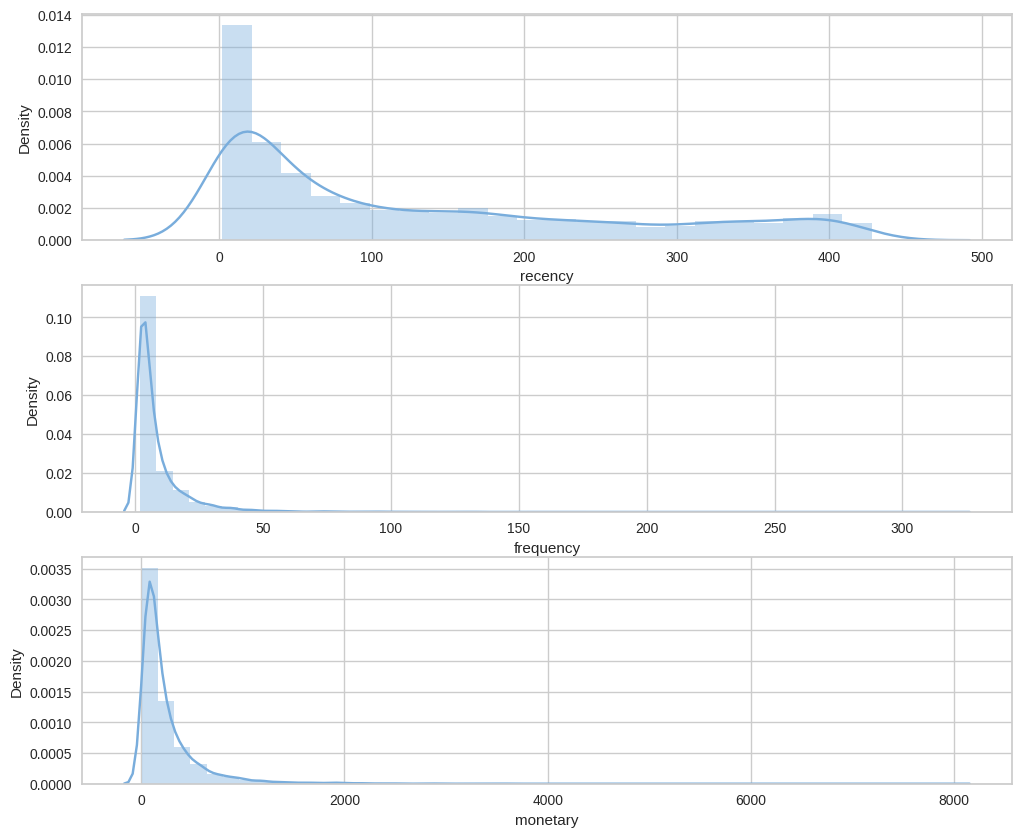

In [30]:
plt.figure(figsize=(12,10))


plt.subplot(3, 1, 1); sns.distplot(rfm['recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm['monetary'])

plt.show()

Based on the previous charts, our distributions seem to be skewed, which raises concerns about the accuracy of our analysis. To address this issue, we need to transform the data into a more symmetrical form. Achieving this requires the use of specific methods to manage the skewness. We will test  **log transformations**, **square root transformations**, and **box-cox transformations** to see which suits our needs better.  

*   **Log transformation** is suitable for variables that have a large range of values, as it compresses the data towards the lower end of the range.
*   **Square root transformation** is ideal for variables with a skewed distribution, as it reduces the skewness and makes the data more symmetrical.
* **Box-cox transformation** is a powerful tool that can handle a wide range of transformations by adjusting the data's power parameter to achieve a more symmetrical distribution. However, it's important to note that these transformations are only suitable for variables that have positive values.

 ‚ú® By applying these methods, we can achieve a more symmetric distribution that will make it easier to analyze and draw meaningful insights from the data, increasing the accuracy and reliability of our analysis.

In [31]:
from scipy import stats
def skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

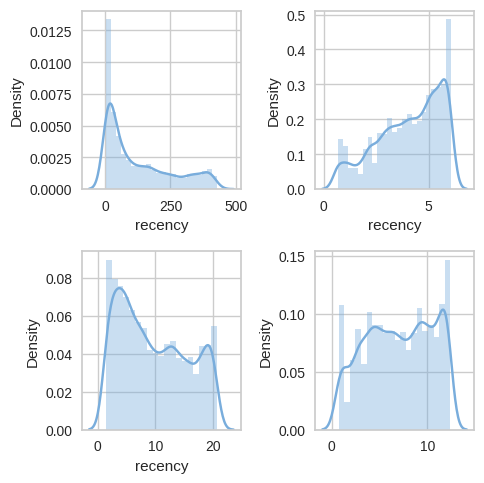

Log Transform : The skew coefficient of 0.88 to -0.56
Square Root Transform : The skew coefficient of 0.88 to 0.33
Box-Cox Transform : The skew coefficient of 0.88 to -0.13


In [32]:
skewness('recency')


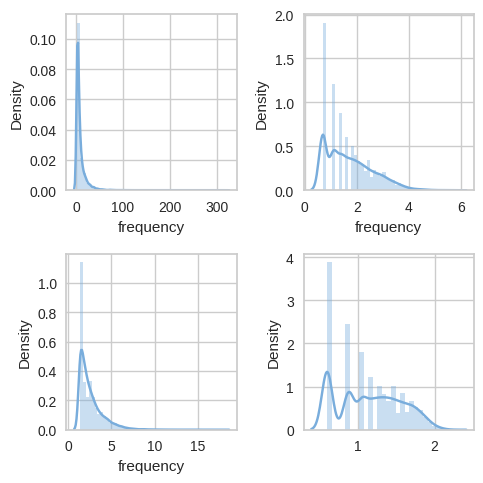

Log Transform : The skew coefficient of 6.61 to 0.74
Square Root Transform : The skew coefficient of 6.61 to 2.17
Box-Cox Transform : The skew coefficient of 6.61 to 0.14


In [33]:
skewness('frequency')

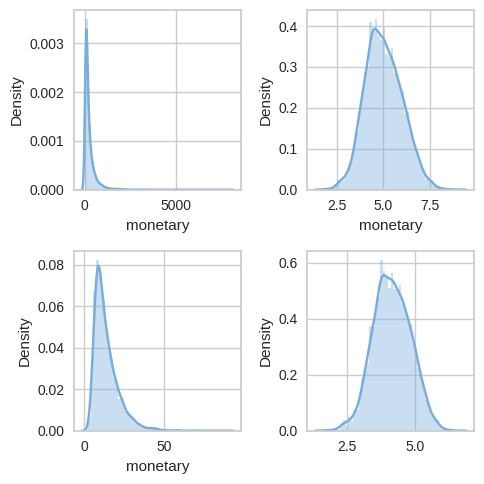

Log Transform : The skew coefficient of 5.95 to 0.21
Square Root Transform : The skew coefficient of 5.95 to 1.85
Box-Cox Transform : The skew coefficient of 5.95 to 0.0


In [34]:
skewness('monetary')

The graphs presented above illustrate that variables with box-cox transformation exhibit a more symmetrical form compared to other transformations. However, the recency variable already has a low skewness coefficient and therefore, we couldn't observe any significant improvement. As a result, it is advisable to retain its current form. To confirm our findings, we utilized the skew function to calculate each variable.

We can use this transformed data to update the RFM table by running a script that incorporates the newly transformed values.

In [35]:
rfm_fixed = pd.DataFrame()
rfm_fixed['recency'] = rfm['recency']
rfm_fixed['frequency'] = stats.boxcox(rfm['frequency'])[0]
rfm_fixed['monetary'] = stats.boxcox(rfm['monetary'])[0]
rfm_fixed.tail()

recency  frequency  monetary
21966       91   0.603187  3.857759
21969      153   1.268200  3.993783
21971       11   1.785369  4.514264
21972      144   1.056890  3.427758
21975      189   1.056890  2.767924

Now, the variables in our dataset have different means and variances, so we need to normalize them. One way to do this is by using the StandardScaler object from the scikit-learn library. This will help us to standardize the variables and make them more comparable.

In [36]:
scaler =  StandardScaler()
scaler.fit(rfm_fixed)
rfm_normalized = scaler.fit_transform(rfm_fixed)
print(rfm_normalized.mean(axis=0).round(2))
print(rfm_normalized.std(axis=0).round(2))

[ 0. -0. -0.]
[1. 1. 1.]


ü•≥ Our means are equal to zero and the standard deviantion is 1! Great success!

In [37]:
column_names = ['recency', 'frequency', 'monetary']

rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=column_names)

In [38]:
rfm_normalized_df.head()

recency  frequency  monetary
0  0.254196   1.343377  1.408741
1 -0.952765   1.343377  1.343702
2 -0.578996  -1.338148 -0.211759
3 -0.072851  -1.338148 -0.313852
4 -0.983913   0.449635  0.661810

Now we can move on to clustering.

## üåç K-Means for Clustering

We must determine which hyperparameter fits the data to make our clustering reach its maximum performance. For this, I'm using the elbow method to decide which number of clusters is the best for our model and data.

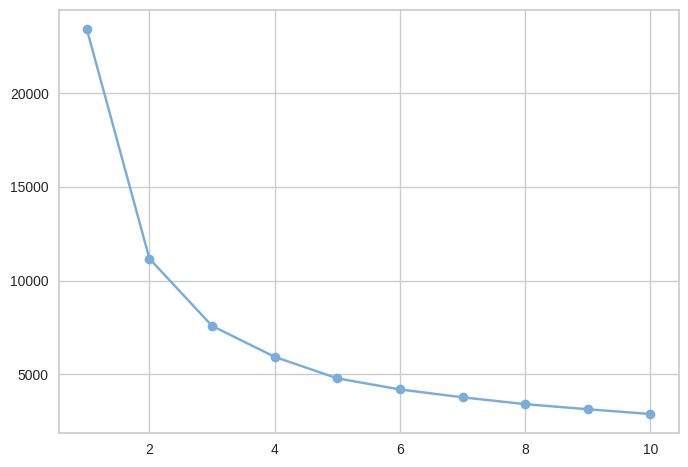

In [39]:
n_clusters = range(1, 11)
cluster_sse = []
for i in n_clusters:
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(rfm_normalized_df)
    cluster_sse.append(kmeans.inertia_)

plt.plot(n_clusters, cluster_sse, marker = "o")
plt.show()

In [40]:
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized_df)

    distortions.append(sum(np.min(cdist(rfm_normalized_df, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_normalized_df.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(rfm_normalized_df, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / rfm_normalized_df.shape[0]

    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
for key, val in mapping1.items():
    print(f'{key} : {val}')


1 : 1.5825849404945427
2 : 1.0936015991553545
3 : 0.8991781221269809
4 : 0.7909708069636141
5 : 0.7143207477443343
6 : 0.6608769932181991
7 : 0.6274344939799035
8 : 0.6044195839136377
9 : 0.5792987995905764
10 : 0.5518839993432774
11 : 0.5331685077562803
12 : 0.5155589011218412
13 : 0.5010824180286944
14 : 0.4861082636158843
15 : 0.4749950586331073
16 : 0.46475530654394037
17 : 0.45646808264944305
18 : 0.4462380528980694
19 : 0.43720892630832636


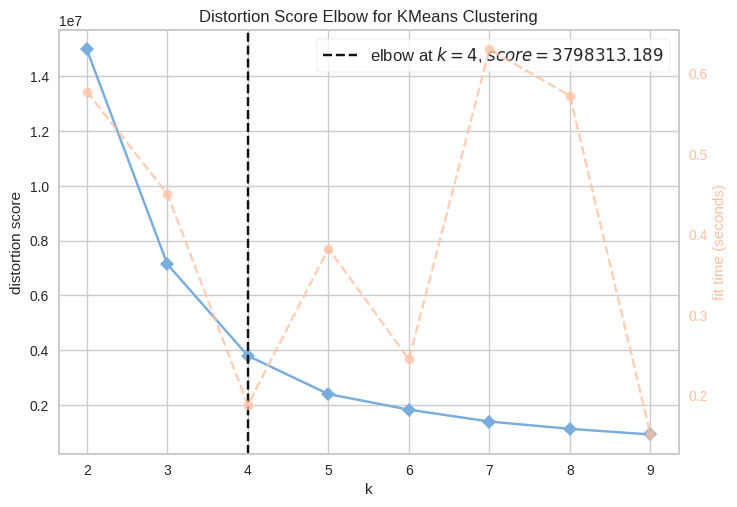

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [41]:
X, y = load_nfl()

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=42), X, k=(2,10))

It seems that either k=3 or k=4 might fit our needs. Let's take a look at each and decide which gives us a more detailed view of the clients.

**K= 3**

In [42]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm_normalized_df)
model.labels_.shape

(7805,)

In [43]:
rfm.shape

(7805, 9)

In [44]:
rfm["cluster"] = model.labels_
rfm.head()

user_id  recency  frequency  monetary recency_score frequency_score  \
2         3      161         19   631.488             2               5   
12       13        6         19   587.972             5               5   
13       14       54          2   118.404             3               1   
15       16      119          2   107.272             3               1   
16       17        2          7   284.372             5               4   

   monetary_score rfm_score         segment  cluster  
2               5        25       cant_lose        0  
12              5        55       champions        0  
13              3        31  about_to_sleep        1  
15              2        31  about_to_sleep        1  
16              4        54       champions        0

In [45]:
rfm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(1)

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0          54.8      17.2    494.9  3083
1          79.4       3.7    103.8  2814
2         319.5       3.0     84.4  1908

 **K=4**

In [46]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_normalized_df)
model.labels_.shape

rfm["cluster"] = model.labels_
rfm.head()
rfm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(1)

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0          87.5       2.7     72.8  1771
1          42.0      23.7    674.7  1787
2         330.8       2.9     81.7  1705
3          81.8       6.8    198.7  2542

Based on the tables above, we can compare the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 clusters. It appears that using k=4 provides a more detailed distribution of our customer base.
Below, we will analyze our data with 4 clusters.

### ü™ê Clusters Exploration & Visualization

In [47]:
df_normalized = pd.DataFrame(rfm_normalized_df, columns=['recency', 'frequency', 'monetary'])
df_normalized['id'] = rfm.index
df_normalized['cluster'] = model.labels_
df_normalized.head()

recency  frequency  monetary  id  cluster
0  0.254196   1.343377  1.408741   2        1
1 -0.952765   1.343377  1.343702  12        1
2 -0.578996  -1.338148 -0.211759  13        0
3 -0.072851  -1.338148 -0.313852  15        0
4 -0.983913   0.449635  0.661810  16        3

In [48]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['id', 'cluster'],
                      value_vars=['recency','frequency','monetary'],
                      var_name='attribute',
                      value_name='value')
df_nor_melt.head()

id  cluster attribute     value
0   2        1   recency  0.254196
1  12        1   recency -0.952765
2  13        0   recency -0.578996
3  15        0   recency -0.072851
4  16        3   recency -0.983913

In [49]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23415 entries, 0 to 23414
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         23415 non-null  int64  
 1   cluster    23415 non-null  int32  
 2   attribute  23415 non-null  object 
 3   value      23415 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 640.4+ KB


In [50]:
# Aggregate data by each customer
fig1 = df_nor_melt.groupby('cluster').agg({'id': lambda x: len(x)}).reset_index()


# Rename columns
fig1.rename(columns={'id': 'count'}, inplace=True)
fig1['percent'] = (fig1['count'] / fig1['count'].sum()) * 100
fig1['percent'] = fig1['percent'].round(1)

fig1.head()

cluster  count  percent
0        0   5313     22.7
1        1   5361     22.9
2        2   5115     21.8
3        3   7626     32.6

In [51]:
fig = px.treemap(fig1, path=['cluster'],values='count'
                 , width=800, height=400
                 ,title="Distribution of Clusters")

fig.update_layout(
    treemapcolorway = colors, #predefined colors on the header of notebook
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

**Recency x Frequency**

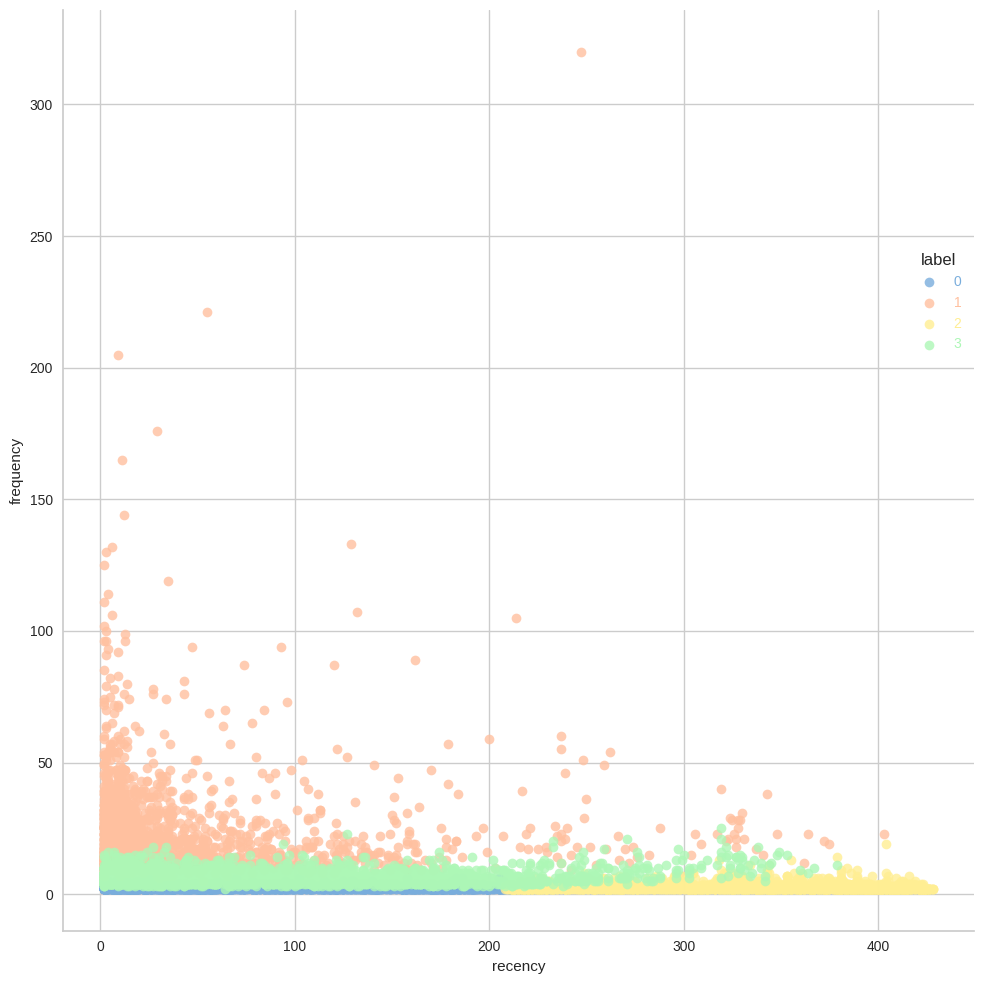

In [52]:
data = pd.DataFrame(data=rfm,columns=['user_id','cluster','recency','frequency','monetary'])

facet = sns.lmplot(data=data, x='recency', y='frequency', hue='cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
# change label colors
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

**Monetary x Frequency**

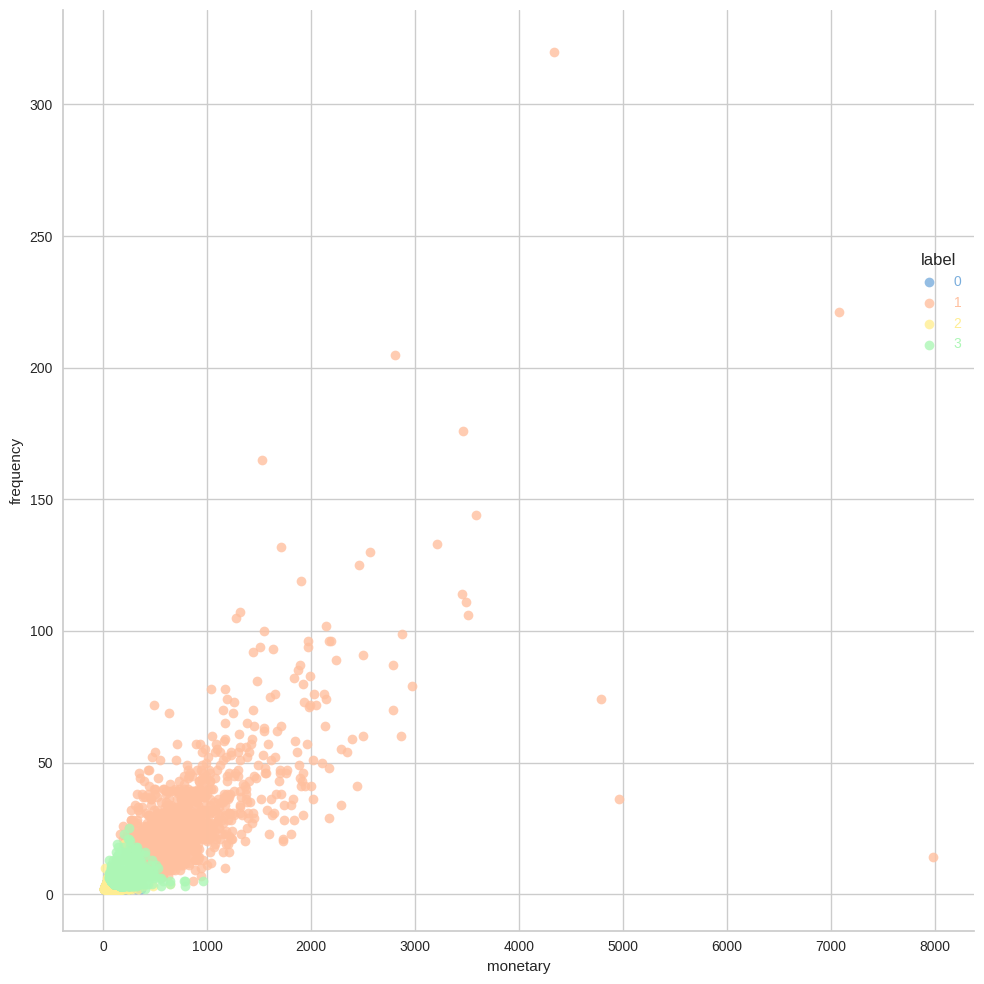

In [53]:
# fig, ax = plt.subplots(figsize=(10, 8))
facet = sns.lmplot(data=data, x='monetary', y='frequency', hue='cluster', height=10,
                   fit_reg=False, legend=False)


leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

In [54]:
fig = px.scatter_3d(rfm,x='recency', y='frequency', z='monetary',
              color='cluster')
fig.update_layout(showlegend=True, title='Distribution of Clusters on a 3d Scatter Plot')

fig.show()

## üåù Interpreting the Results

In [55]:
cluster_avg = rfm[['cluster','recency','frequency','monetary']].groupby(['cluster']).mean()
cluster_avg

recency  frequency    monetary
cluster                                   
0         87.465839   2.685488   72.754857
1         41.971461  23.709569  674.691396
2        330.772434   2.859824   81.688877
3         81.803304   6.759638  198.651380

In [56]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['cluster','segment'],).agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'user_id': 'count'}, inplace=True)
rfm1['percent'] = (rfm1['count'] / rfm1.groupby('cluster')['count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(2)

rfm1

cluster              segment  count  percent
0         0       about_to_sleep    516    29.14
1         0              at_risk     54     3.05
2         0            champions      1     0.06
3         0          hibernating    519    29.31
4         0      loyal_customers      1     0.06
5         0       need_attention     77     4.35
6         0        new_customers     95     5.36
7         0  potential_loyalists    376    21.23
8         0            promising    132     7.45
9         1              at_risk     22     1.23
10        1            cant_lose    140     7.83
11        1            champions    829    46.39
12        1      loyal_customers    795    44.49
13        1       need_attention      1     0.06
14        2              at_risk    295    17.30
15        2            cant_lose      4     0.23
16        2          hibernating   1406    82.46
17        3       about_to_sleep     49     1.93
18        3              at_risk    580    22.82
19        3            cant_lose     47     1.85
20        3            champions    299    11.76
21        3          hibernating     52     2.05
22        3      loyal_customers    667    26.24
23        3       need_attention    266    10.46
24        3  potential_loyalists    582    22.90

In [57]:
rfm.groupby(['cluster'])['recency'].agg(['count','mean','median','max','min'])

count        mean  median  max  min
cluster                                     
0         1771   87.465839    77.0  212    2
1         1787   41.971461    17.0  403    2
2         1705  330.772434   340.0  428  208
3         2542   81.803304    52.0  379    2

Cluster | Description
-------------------|------------------
**0** |Customers who made their latest transaction **a while ago**.
**1** | Customers who made their last transaction  **recently**.
**2** | Customers who made their last transaction **a long time ago**.
**3** | Customers who made their last transaction **a while ago**.

In [58]:
rfm.groupby(['cluster'])['frequency'].agg(['count','mean','median','max','min'])

count       mean  median  max  min
cluster                                    
0         1771   2.685488     3.0    7    2
1         1787  23.709569    18.0  320    5
2         1705   2.859824     2.0   19    2
3         2542   6.759638     6.0   25    2

Cluster | Description
-------------------|------------------
**0** |Customers with the **lowest** purchase frequency.
**1** | Customers with the **highest** purchase frequency.
**2** | Customers with a **low** purchase frequency.
**3** | Customers who made **few** purchases.

In [59]:
rfm.groupby(['cluster'])['monetary'].agg(['count','mean','median','max','min'])

count        mean   median       max      min
cluster                                               
0         1771   72.754857   70.840   358.248    6.072
1         1787  674.691396  527.252  7979.620  156.860
2         1705   81.688877   69.828   637.560    7.084
3         2542  198.651380  185.196   954.316   53.636

There's really not that much of a difference between the average value spent.

Cluster | Description
-------------------|------------------
**0** |Customers with the **medium** spend.
**1** | Customers with the **highest** purchase spend.
**2** | Customers with a **medium** purchase spend.
**3** | Customers who made **large** purchases.

In [66]:
rfm.cluster.value_counts(normalize=True)

3    0.325689
1    0.228956
0    0.226906
2    0.218450
Name: cluster, dtype: float64

In [65]:
revenue_per_segment = rfm.groupby(['cluster'])['monetary'].sum()
revenue_per_segment/sum(revenue_per_segment) *100


cluster
0     6.511551
1    60.930338
2     7.038679
3    25.519432
Name: monetary, dtype: float64

Now let's take the df2 created in the beginning of our analysis and merge with rfm to see more characteristics about these clusters.

In [60]:
merged_df = pd.merge(rfm, df2, on='user_id', how='inner')


In [63]:
merged_df.groupby(['cluster']).describe().transpose()

cluster                        0             1            2             3
user_id      count    246.000000    982.000000   339.000000    880.000000
             mean   10762.715447  10617.942974  9903.079646  11013.900000
             std     6294.094165   6342.139813  6474.285270   6564.853671
             min       14.000000     32.000000    40.000000     17.000000
             25%     5804.250000   5159.750000  4499.000000   5205.500000
...                          ...           ...          ...           ...
Retail store min        0.000000      0.000000     0.000000      0.000000
             25%        0.000000      0.000000     0.000000      0.000000
             50%        0.000000      4.500000     0.000000      0.000000
             75%        0.000000     10.000000     0.000000      3.000000
             max        0.000000     72.000000     7.000000      9.000000

[184 rows x 4 columns]

Cluster |
-------------------|
**0** |
**1** |
**2** |
**3** |

## ‚≠êÔ∏è Summary of each Cluster

Cluster | % of Total | RFM Labels | Description
-------------------|------------------|------------------|------------------|
**0** |33%|49% Loyal Customers; 46% Champions| Customers who purchase frequently, spend the highest amounts and have recently made a transaction.|
**1** |29%|91% Hibernating|Customers who made their last transaction a long time ago,rarely bought anything, and spent the least.|
**2** |20%|44% Potential Loyalists; 23% About to Sleep| Customers who made their last transaction a while ago, seldom make transactions, but spent a considerable amount.|
**3** |18%|50% At Risk| Customers who made their last transaction a long time ago, have a lower purchase frequency, but made large purchases in the past.|